# Amazon Fine Food Reviews: K Nearest Neighbor

# Loading data

In [26]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


# using the SQLite Table to read data.
con = sqlite3.connect('../input/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [27]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 1. Preprocessing and cleaning of text data

In [28]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [29]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [30]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [31]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [32]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [33]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [34]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [35]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [36]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"needn't", 'into', 'had', 'if', 'for', 'over', 'such', 'more', 'are', 'should', 'under', "doesn't", 'a', 'down', 'doesn', 'me', 'off', 'the', 'we', 'myself', 'yourselves', 'haven', 'both', "weren't", 'these', 'hadn', "wasn't", 'i', "shan't", 'too', 'himself', 'has', 'mustn', 'to', 'other', "mightn't", 'was', 'hers', 'those', 'it', 'below', "shouldn't", 'don', 'she', 'will', "it's", 'aren', 'so', 'them', "should've", 'most', 'no', 'did', 'of', 't', 'couldn', 'your', 'after', 'then', "you've", 'their', 'and', 'y', "couldn't", 'him', 'only', 'wasn', 'wouldn', 'about', 're', "aren't", 'hasn', 'ours', 'having', 'my', 'once', 'this', 'each', 'against', 'yours', 'does', 'an', 'where', 'own', 'how', 'd', 'from', 'm', 'what', 'won', 'by', 'his', 'as', 'again', 'ain', 'here', 'than', 'can', 'shan', 'who', 'but', "she's", 'nor', 'its', 'why', 've', 'before', "hasn't", 'do', 'while', 'he', "won't", 'needn', 'ourselves', 'same', 'with', 'above', 'o', 'or', 'which', 'on', 'up', 'that', 'themselves'

In [37]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [38]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [39]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# 2. Sorting data based on time

In [40]:
final['Time'] = pd.to_datetime(final['Time'])
# Random sampling
df = final.take(np.random.permutation(len(final))[:8000])

In [41]:
# Sort by time
data = df.sort_values(by='Time')
data['Score'] = data['Score'].map({"positive":1, "negative":0})
print(data.shape)
print(data['Score'].value_counts())

(8000, 11)
1    6686
0    1314
Name: Score, dtype: int64


# 3. Spliting into train and test based on time (70:30)

In [42]:
from sklearn.model_selection import train_test_split

# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values, data['Score'].values, test_size=0.3, shuffle=False)

# 4. Building vectorizer(BOW) on train data vocabulary

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

count_vect = CountVectorizer()  
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (5600, 10078)
Test Data Size:  (2400, 10078)


In [44]:
# Forward Cross Validation split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

# Forward Chaining Cross Validation
n_splits = 10  
# no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store different k values
k_acc = []

for k in range(1,neigh_max,1):
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
    if(acc_list):        
        acc_nparr = np.array(acc_list) 
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc) 

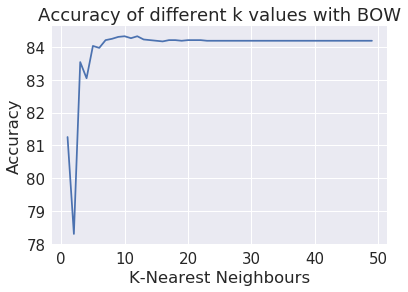

In [45]:
# Accuracy plot
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
plt.plot(np.arange(1,50,1),k_acc)
plt.xlabel("K-Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy of different k values with BOW")
plt.show()

** With Forward Chaining cross validation the best accuracy is between K=5-14 after 15 the K value is tapering off.
This is with 8000 datapoints .**

## 4.1  KNN with 'brute' algorithm

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')

param_grid = {'n_neighbors':np.arange(1,50,2)} 

#time based splitting
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'n_neighbors': 9}
Best Accuracy: 84.30%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.5min finished


Accuracy on test set: 81.46%
Confusion Matrix:
 [ [TN  FP]
 [FN TP] ]



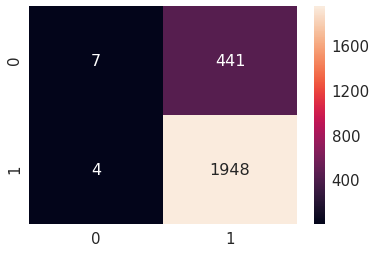

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Accuracy on Test data
knn = KNeighborsClassifier(n_neighbors=9, algorithm='brute')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %.2f%%"%(accuracy_score(y_test, y_pred)*100))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Confusion Matrix:\n [ [TN  FP]\n [FN TP] ]\n")

## 4.2  KNN with 'kd tree' algorithm

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {'n_neighbors':np.arange(1,50,2)}
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'n_neighbors': 9}
Best Accuracy: 84.30%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.4min finished


Accuracy on test set: 81.458%
Confusion Matrix:
 [ [TN  FP]
 [FN TP] ]



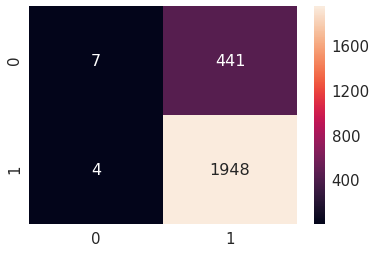

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Accuracy on Test data
knn = KNeighborsClassifier(n_neighbors=9,algorithm='kd_tree')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Confusion Matrix:\n [ [TN  FP]\n [FN TP] ]\n")

# 5.  TF-IDF 

In [50]:
from sklearn.model_selection import train_test_split

# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

tfidf = TfidfVectorizer(ngram_range=(1,2)) 
X_train = tfidf.fit_transform(X_train)
X_train = preprocessing.normalize(X_train)

X_test = tfidf.transform(X_test)
X_test = preprocessing.normalize(X_test)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (5600, 150684)
Test Data Size:  (2400, 150684)


## 5.1 KNN with 'brute' algorithm

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')

param_grid = {'n_neighbors':np.arange(1,50,2)} 

#time based splitting
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 85.11%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.5min finished


Accuracy on test set: 82.83%
Confusion Matrix:
 [ [TN  FP]
 [FN TP] ]



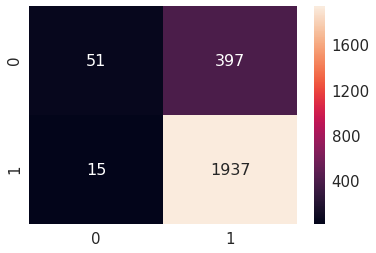

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Accuracy on Test data
knn = KNeighborsClassifier(n_neighbors=7, algorithm='brute')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %.2f%%"%(accuracy_score(y_test, y_pred)*100))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Confusion Matrix:\n [ [TN  FP]\n [FN TP] ]\n")

## 5.2  KNN with 'kd tree' algorithm

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {'n_neighbors':np.arange(1,50,2)}
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 85.11%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.5min finished


Accuracy on test set: 82.833%
Confusion Matrix:
 [ [TN  FP]
 [FN TP] ]



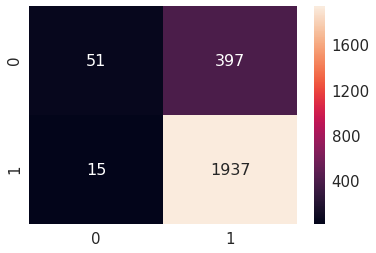

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Accuracy on Test data
knn = KNeighborsClassifier(n_neighbors=7,algorithm='kd_tree')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Confusion Matrix:\n [ [TN  FP]\n [FN TP] ]\n")

 # 6. Word2Vec

In [56]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in df['CleanedText'].values:
    list_of_sent.append(sent.split())

In [57]:
print(df['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

purchas plant differ date plant arriv healthi quick joel great place purchas carnivor plant high recommend
*****************************************************************
['purchas', 'plant', 'differ', 'date', 'plant', 'arriv', 'healthi', 'quick', 'joel', 'great', 'place', 'purchas', 'carnivor', 'plant', 'high', 'recommend']


In [58]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model = Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [59]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4140
sample words  ['purchas', 'plant', 'differ', 'date', 'arriv', 'healthi', 'quick', 'great', 'place', 'carnivor', 'high', 'recommend', 'realli', 'enjoy', 'arizona', 'pomegran', 'green', 'tea', 'light', 'refresh', 'sure', 'much', 'better', 'carbon', 'drink', 'easi', 'use', 'packet', 'make', 'quart', 'tri', 'coffe', 'tast', 'bitter', 'aroma', 'buy', 'get', 'big', 'well', 'good', 'product', 'happi', 'open', 'bag', 'time', 'ran', 'pretti', 'size', 'sort', 'brown']


In [60]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


# 7. Average Word2Vec

In [61]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

8000
50


In [62]:
from sklearn.model_selection import train_test_split

# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

## 7.1  KNN with 'brute' algorithm

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')

param_grid = {'n_neighbors':np.arange(1,50,2)} 

#time based splitting
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'n_neighbors': 17}
Best Accuracy: 84.18%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.3min finished


Accuracy on test set: 81.33%
Confusion Matrix:
 [ [TN  FP]
 [FN TP] ]



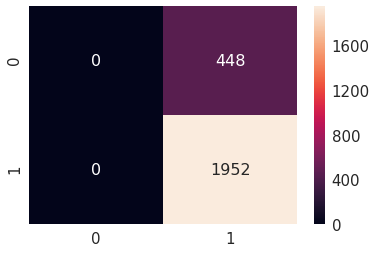

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Accuracy on Test data
knn = KNeighborsClassifier(n_neighbors=17, algorithm='brute')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %.2f%%"%(accuracy_score(y_test, y_pred)*100))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Confusion Matrix:\n [ [TN  FP]\n [FN TP] ]\n")

## 7.2  KNN with 'kd tree' algorithm

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {'n_neighbors':np.arange(1,50,2)}
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'n_neighbors': 17}
Best Accuracy: 84.18%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.4min finished


Accuracy on test set: 81.33%
Confusion Matrix:
 [ [TN  FP]
 [FN TP] ]



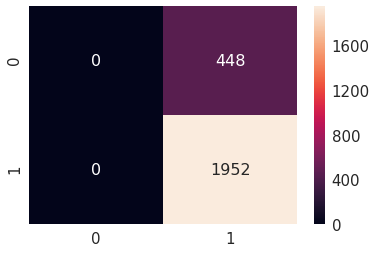

In [66]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Accuracy on Test data
knn = KNeighborsClassifier(n_neighbors=17, algorithm='kd_tree')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %.2f%%"%(accuracy_score(y_test, y_pred)*100))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Confusion Matrix:\n [ [TN  FP]\n [FN TP] ]\n")

# 8. TF-IDF weighted Word2Vec

In [67]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(df['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (8000, 200671)
the number of unique words including both unigrams and bigrams  200671


In [68]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [69]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

8000
50


In [70]:
from sklearn.model_selection import train_test_split

# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

## 8.1 KNN with 'brute' algorithm

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')

param_grid = {'n_neighbors':np.arange(1,50,2)} 

#time based splitting
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'n_neighbors': 15}
Best Accuracy: 84.18%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.3min finished


Accuracy on test set: 81.33%
Confusion Matrix:
 [ [TN  FP]
 [FN TP] ]



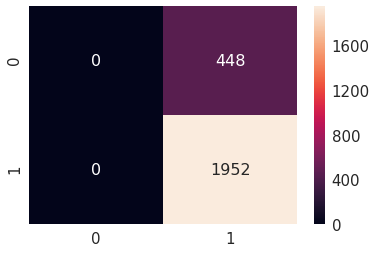

In [72]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Accuracy on Test data
knn = KNeighborsClassifier(n_neighbors=15, algorithm='brute')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %.2f%%"%(accuracy_score(y_test, y_pred)*100))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Confusion Matrix:\n [ [TN  FP]\n [FN TP] ]\n")

## 8.2  KNN with 'kd tree' algorithm

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')

param_grid = {'n_neighbors':np.arange(1,50,2)} 

#time based splitting
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'n_neighbors': 15}
Best Accuracy: 84.18%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.1min finished


Accuracy on test set: 81.33%
Confusion Matrix:
 [ [TN  FP]
 [FN TP] ]



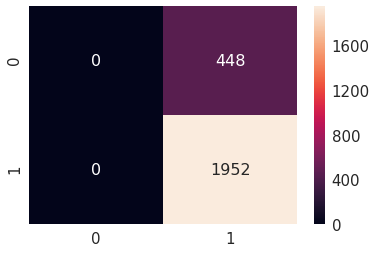

In [74]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Accuracy on Test data
knn = KNeighborsClassifier(n_neighbors=15, algorithm='kd_tree')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %.2f%%"%(accuracy_score(y_test, y_pred)*100))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
print("Confusion Matrix:\n [ [TN  FP]\n [FN TP] ]\n")

# Model Preformance Table

# ![image](https://image.ibb.co/jMxnjz/Untitled.png)

# Observation
* By doing 10 fold cross validation we can see that, In both the algorithms ('kdtree' & 'brute') KNN is is taking K value between 5 to 20 and this is only with 8000 datapoints.
* KNN with kd-tree and brute algorithm gives approximately similar results
* The best accuracy is 82.833% from tf-idf featureization